In [128]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# the CSV file containing titles and artists/bands
songs = pd.read_csv("rockdata.csv")

# extracting title and names of the artists/bands
titles = songs['Song Clean'].tolist()
artists = songs['ARTIST CLEAN'].tolist()

# creating a list of titles+aritsts to be queried
title_artist = []
for i in range(0, len(titles)):
    title_artist.append(titles[i] + " " + artists[i])

In [3]:
import json
import spotipy
import spotipy.oauth2 as oauth2

def read_api_key(filepath):
    with open(filepath, 'r') as f:
        return f.read().replace('\n','')

clientID = read_api_key('ClientID.txt')
clientSecret = read_api_key('ClientSecret.txt')
username = read_api_key('username.txt')
credentials = spotipy.oauth2.SpotifyClientCredentials(client_id = clientID, client_secret = clientSecret)
sp = spotipy.Spotify(client_credentials_manager = credentials)

In [4]:
# returns url of songs as a list
def get_url(title_artist):
    sp = spotipy.Spotify(client_credentials_manager = credentials)
    url_list = []
    for song in title_artist:
        try:
            url_list.append(sp.search(q=song, type='track', limit=1)['tracks']['items'][0]['external_urls']['spotify'])
        except:
            print(song)
    return url_list

In [5]:
# returns dataframe of audio_features
def get_audio_features(urls):
    audio_features_dict = sp.audio_features(tracks=urls)
    df = pd.DataFrame.from_dict(audio_features_dict)
    df = df.drop(columns=['time_signature', 'duration_ms', 'mode', 'type', 'id', 'uri','track_href','analysis_url'])
    return df

# uses get_audio_features to search 100 songs at a time
def audio_features(urls):
    j=0
    dataframe = pd.DataFrame()
    while(True):
        if j+100 < len(urls):
            df = get_audio_features(urls[j:j+100])
            dataframe = dataframe.append(df)
            j = j+100
        else:
            df = get_audio_features(urls[j:len(urls)])
            dataframe = dataframe.append(df)
            break
    dataframe.reset_index(inplace = True)
    dataframe.drop(columns=['index'], inplace=True)
    return dataframe

In [6]:
# getting the urls of each song
urls = get_url(title_artist)

retrying ...4secs
retrying ...1secs
retrying ...2secs
retrying ...3secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...3secs
retrying ...3secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...2secs


In [7]:
# gets the audio features of each song

dataframe = audio_features(urls)
dataframe['artist'] = songs['ARTIST CLEAN']
dataframe['title'] = songs['Song Clean']

In [8]:
# scalling loudness key and tempo so the values of all features are between 0 and 1

scaler = MinMaxScaler()

scaler.fit(dataframe[['loudness']])
dataframe[['loudness']] = scaler.transform(dataframe[['loudness']])

scaler.fit(dataframe[['key']])
dataframe[['key']] = scaler.transform(dataframe[['key']])

scaler.fit(dataframe[['tempo']])
dataframe[['tempo']] = scaler.transform(dataframe[['tempo']])

In [9]:
dataframe.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist,title
0,0.425,0.681,0.090909,0.675499,0.0316,0.02290,0.000219,0.0543,0.933,0.606763,.38 Special,Caught Up in You
1,0.418,0.775,0.363636,0.630254,0.0333,0.05310,0.001250,0.0932,0.845,0.572088,.38 Special,Fantasy Girl
2,0.567,0.559,0.818182,0.603484,0.0288,0.00888,0.001310,0.0764,0.898,0.589238,.38 Special,Hold On Loosely
3,0.659,0.505,0.000000,0.484391,0.0302,0.05300,0.000000,0.0544,0.879,0.594184,.38 Special,Rockin' Into the Night
4,0.646,0.426,0.000000,0.582672,0.0480,0.08580,0.072700,0.0746,0.462,0.577969,10cc,Art For Arts Sake


In [10]:
# k-means clustering algorithm with 50 clusters

km = KMeans(n_clusters=50)
prediction = km.fit_predict(dataframe[['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
                                      'instrumentalness', 'liveness', 'valence', 'tempo']])
dataframe['cluster'] = prediction

In [71]:
dataframe.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist,title,cluster
0,0.425,0.681,0.090909,0.675499,0.0316,0.02290,0.000219,0.0543,0.933,0.606763,.38 Special,Caught Up in You,24
1,0.418,0.775,0.363636,0.630254,0.0333,0.05310,0.001250,0.0932,0.845,0.572088,.38 Special,Fantasy Girl,5
2,0.567,0.559,0.818182,0.603484,0.0288,0.00888,0.001310,0.0764,0.898,0.589238,.38 Special,Hold On Loosely,49
3,0.659,0.505,0.000000,0.484391,0.0302,0.05300,0.000000,0.0544,0.879,0.594184,.38 Special,Rockin' Into the Night,32
4,0.646,0.426,0.000000,0.582672,0.0480,0.08580,0.072700,0.0746,0.462,0.577969,10cc,Art For Arts Sake,38


In [63]:
# returns a dataframe of songs similar a spicific song in dataframe

def recommend(song, dataframe):
    try:
        clt = dataframe[dataframe.title == song].cluster.values[0]
        df = dataframe[dataframe.cluster == clt][['title', 'artist']].reset_index().drop(columns=['index'])
        return df
    except:
        print('The requested song is not in dataframe.')

In [76]:
recommend('Back In Black', dataframe).head()

,title,artist
0,Back In Black,AC/DC
1,Dirty Deeds Done Dirt Cheap,AC/DC
2,"Baby, Please Don't Go",Aerosmith
3,Toys in the Attic,Aerosmith
4,Roller,April Wine


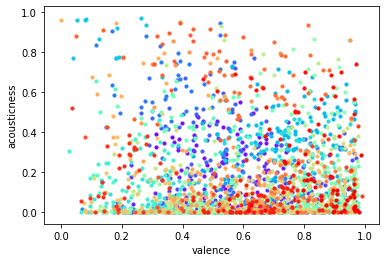

In [124]:
plt.xlabel('valence')
plt.ylabel('acousticness')
for j in range(0,50):
    df = dataframe[dataframe.cluster == j]
    colors = cm.rainbow(np.linspace(0, 1, 50))
    plt.scatter(df.valence, df.acousticness, color=colors[j], s=10)

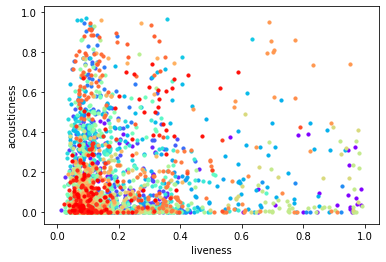

In [125]:
plt.xlabel('liveness')
plt.ylabel('acousticness')
for j in range(0,50):
    df = dataframe[dataframe.cluster == j]
    colors = cm.rainbow(np.linspace(0, 1, 50))
    plt.scatter(df.liveness, df.acousticness, color=colors[j], s=10)

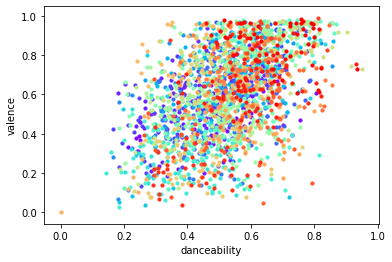

In [126]:
plt.xlabel('danceability')
plt.ylabel('valence')
for j in range(0,50):
    df = dataframe[dataframe.cluster == j]
    colors = cm.rainbow(np.linspace(0, 1, 50))
    plt.scatter(df.danceability, df.valence, color=colors[j], s=10)

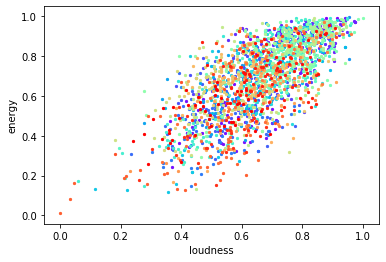

In [127]:
plt.xlabel('loudness')
plt.ylabel('energy')
for j in range(0,50):
    df = dataframe[dataframe.cluster == j]
    colors = cm.rainbow(np.linspace(0, 1, 50))
    plt.scatter(df.loudness, df.energy, color=colors[j], s=5)

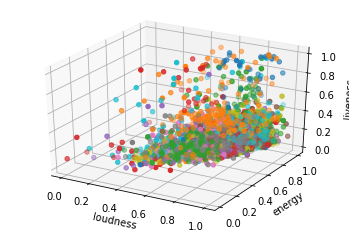

In [120]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('loudness')
ax.set_ylabel('energy')
ax.set_zlabel('liveness')
for j in range(0,50):
    df = dataframe[dataframe.cluster == j]
    ax.scatter(df.loudness, df.energy, df.liveness )


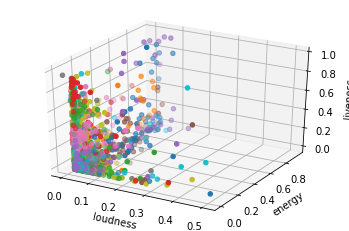

In [121]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('loudness')
ax.set_ylabel('energy')
ax.set_zlabel('liveness')
for j in range(0,50):
    df = dataframe[dataframe.cluster == j]
    ax.scatter(df.speechiness, df.instrumentalness, df.acousticness)

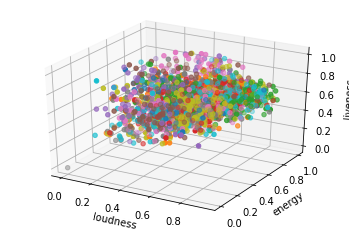

In [122]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('loudness')
ax.set_ylabel('energy')
ax.set_zlabel('liveness')
for j in range(0,50):
    df = dataframe[dataframe.cluster == j]
    ax.scatter(df.danceability, df.valence, df.tempo)